In [1]:
import sys
import os

# Inserting siebling folder to sys. Ensures other code can be ran
# Note: Must have breast_cancer_classifier folder in the parent of the current folder
sys.path.insert(1, os.path.abspath("../breast_cancer_classifier"))

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np

from src.modeling.run_model_single import (
    load_model, load_inputs, process_augment_inputs, batch_to_tensor
)
import src.utilities.pickling as pickling

In /home/frfa/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/frfa/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/frfa/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
import pandas as pd

In [4]:
shared_parameters = {
    "device_type": "cpu", #gpu
    "gpu_number": 0,
    "max_crop_noise": (100, 100),
    "max_crop_size_noise": 100,
    "batch_size": 1,
    "seed": 0,
    "augmentation": True,
    "use_hdf5": True,
}

# Loading INbreast meta data

Including png_file locations

In [5]:
meta_data_base = "meta_data"
meta_df = pd.read_csv(
    meta_data_base + "/INbreast_with_img_loc.csv",
    #delimiter = ";"
)

In [6]:
meta_df

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,png_path,png_filename,png_base
0,removed,removed,R,CC,201001,22678622,4,1,../data/INbreast Release 1.0/png_versions/2267...,22678622_61b13c59bcba149e_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions
1,removed,removed,L,CC,201001,22678646,4,3,../data/INbreast Release 1.0/png_versions/2267...,22678646_61b13c59bcba149e_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions
2,removed,removed,R,MLO,201001,22678670,4,1,../data/INbreast Release 1.0/png_versions/2267...,22678670_61b13c59bcba149e_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions
3,removed,removed,L,MLO,201001,22678694,4,3,../data/INbreast Release 1.0/png_versions/2267...,22678694_61b13c59bcba149e_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions
4,removed,removed,R,CC,201001,22614074,2,5,../data/INbreast Release 1.0/png_versions/2261...,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions
...,...,...,...,...,...,...,...,...,...,...,...
405,removed,removed,L,MLO,201001,22613848,2,1,../data/INbreast Release 1.0/png_versions/2261...,22613848_45c7f44839fd9e68_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions
406,removed,removed,L,MLO,200802,24055725,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055725_f0f1a133837b5137_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions
407,removed,removed,R,MLO,200802,24055752,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055752_f0f1a133837b5137_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions
408,removed,removed,L,CC,200802,24055779,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055779_f0f1a133837b5137_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions


# Cropping images

This is done to reduce the size of the images before inputting to models.

In [75]:
# Github library
import src.cropping.crop_single as crop_single

Testing with an example

In [77]:
crop_single.crop_single_mammogram(
    "../data/INbreast/png_versions/20586908_6c613a14b80a8591_MG_R_CC_ANON.png",
    #"../data/INbreast Release 1.0/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm",
    "NO",
    "R-CC",
    "../data/INbreast/png_versions/" + "cropped/" + "cropped_test.png",
    "../data/INbreast/png_versions/" + "cropped/" + "cropped_test.pkl",
    100,
    50,
    )

Cropping all images

In [27]:
for row in meta_df.itertuples():
    if row.View != "CC" and row.View != "MLO":
        continue
    crop_single.crop_single_mammogram(
    row.png_path,
    "NO",
    row.Laterality + "-" + row.View,
    row.png_base + "/cropped/" + row.png_filename,
    row.png_base + "/cropped/" + row.png_filename.replace(".png", ".pkl"),
    1,
    50,
    )

# Get optimal centers

In [28]:
# Github library
import src.optimal_centers.get_optimal_center_single as center_single

In [44]:
for row in meta_df.itertuples():
    if row.View != "CC" and row.View != "MLO":
        continue
    print(row.Index)
    center_single.get_optimal_center_single(
        row.png_base + "/cropped/" + row.png_filename, # cropped_mammogram_path,
        row.png_base + "/cropped/" + row.png_filename.replace(".png", ".pkl") # metadata_path
    )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Bulk Image-Only Model

A dictionary containing the configuration parameters for image-only model, and load the corresponding weights.

In [7]:
def make_pred(shared_parameters, row, meta_df2):
    random_number_generator = np.random.RandomState(shared_parameters["seed"])

    image_only_parameters = shared_parameters.copy()
    image_only_parameters["view"] = row.Laterality + "-" + row.View #"L-CC"
    image_only_parameters["use_heatmaps"] = False
    image_only_parameters["model_path"] = "../breast_cancer_classifier/models/ImageOnly__ModeImage_weights.p"
    model, device = load_model(image_only_parameters)
    
    model_input = load_inputs(
    image_path = row.png_base + "/cropped/" + row.png_filename, #"sample_single_output/cropped.png",
    metadata_path = row.png_base + "/cropped/" + row.png_filename.replace(".png", ".pkl"),  #"sample_single_output/cropped_metadata.pkl",
    use_heatmaps=False,
    )
    
    batch = [
        process_augment_inputs(
            model_input=model_input,
            random_number_generator=random_number_generator,
            parameters=image_only_parameters,
        ),
    ]
    tensor_batch = batch_to_tensor(batch, device)
    
    y_hat = model(tensor_batch)
    
    predictions = np.exp(y_hat.cpu().detach().numpy())[:, :2, 1]
    predictions_dict = {
        "benign": float(predictions[0][0]),
        "malignant": float(predictions[0][1]),
    }
    
    # Assign probabilities to df location
    meta_df2.loc[meta_df2["png_path"] == row.png_path, "benign"] = float(predictions[0][0])
    meta_df2.loc[meta_df2["png_path"] == row.png_path, "malignant"] = float(predictions[0][1])
    
    return predictions_dict

In [8]:
meta_df2 = meta_df[(meta_df.View == "CC") | (meta_df.View == "MLO")]

In [9]:
meta_df2["benign"] = 0
meta_df2["malignant"] = 0

/home/frfa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/frfa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
predictions = []
for row in meta_df2.itertuples():
    print(row.Index)
        
    predictions.append(
        make_pred(shared_parameters, row, meta_df2)
    )

0


/home/frfa/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [11]:
meta_df2

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,png_path,png_filename,png_base,benign,malignant
0,removed,removed,R,CC,201001,22678622,4,1,../data/INbreast Release 1.0/png_versions/2267...,22678622_61b13c59bcba149e_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.118517,0.013212
1,removed,removed,L,CC,201001,22678646,4,3,../data/INbreast Release 1.0/png_versions/2267...,22678646_61b13c59bcba149e_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.144094,0.015284
2,removed,removed,R,MLO,201001,22678670,4,1,../data/INbreast Release 1.0/png_versions/2267...,22678670_61b13c59bcba149e_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.143101,0.009586
3,removed,removed,L,MLO,201001,22678694,4,3,../data/INbreast Release 1.0/png_versions/2267...,22678694_61b13c59bcba149e_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.261987,0.016814
4,removed,removed,R,CC,201001,22614074,2,5,../data/INbreast Release 1.0/png_versions/2261...,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.095521,0.054886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,removed,removed,L,MLO,201001,22613848,2,1,../data/INbreast Release 1.0/png_versions/2261...,22613848_45c7f44839fd9e68_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.038124,0.003948
406,removed,removed,L,MLO,200802,24055725,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055725_f0f1a133837b5137_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.111391,0.016392
407,removed,removed,R,MLO,200802,24055752,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055752_f0f1a133837b5137_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.196672,0.046869
408,removed,removed,L,CC,200802,24055779,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055779_f0f1a133837b5137_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.333808,0.190338


In [12]:
meta_df2.to_csv("meta_data/INbreast_with_pred.csv", index=False)

In [13]:
meta_df2[meta_df2["Bi-Rads"] == "6"]

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,png_path,png_filename,png_base,benign,malignant
33,removed,removed,R,MLO,201001,53581406,1,6,../data/INbreast Release 1.0/png_versions/5358...,53581406_b231a8ba4dd4214f_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.078726,0.035732
35,removed,removed,R,CC,201001,53581460,1,6,../data/INbreast Release 1.0/png_versions/5358...,53581460_b231a8ba4dd4214f_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.077238,0.024816
167,removed,removed,R,CC,200902,20587994,3,6,../data/INbreast Release 1.0/png_versions/2058...,20587994_024ee3569b2605dc_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.036070,0.033778
169,removed,removed,R,MLO,200902,20588046,3,6,../data/INbreast Release 1.0/png_versions/2058...,20588046_024ee3569b2605dc_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.059644,0.048675
188,removed,removed,L,CC,201001,22613650,2,6,../data/INbreast Release 1.0/png_versions/2261...,22613650_dcafa6ba6374ec07_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.098492,0.049828
190,removed,removed,L,MLO,201001,22613702,2,6,../data/INbreast Release 1.0/png_versions/2261...,22613702_dcafa6ba6374ec07_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.087108,0.006668
299,removed,removed,R,CC,201001,22670094,1,6,../data/INbreast Release 1.0/png_versions/2267...,22670094_e1f51192f7bf3f5f_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.017949,0.019343
301,removed,removed,R,MLO,201001,22670147,1,6,../data/INbreast Release 1.0/png_versions/2267...,22670147_e1f51192f7bf3f5f_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.050997,0.023317


In [14]:
meta_df2[meta_df2["Bi-Rads"] == "5"]

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,png_path,png_filename,png_base,benign,malignant
4,removed,removed,R,CC,201001,22614074,2,5,../data/INbreast Release 1.0/png_versions/2261...,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.095521,0.054886
6,removed,removed,R,MLO,201001,22614127,2,5,../data/INbreast Release 1.0/png_versions/2261...,22614127_6bd24a0a42c19ce1_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.147652,0.074018
21,removed,removed,L,MLO,201001,50998059,3,5,../data/INbreast Release 1.0/png_versions/5099...,50998059_66adfbb4f19c76d2_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.112046,0.035438
23,removed,removed,L,CC,201001,50998113,3,5,../data/INbreast Release 1.0/png_versions/5099...,50998113_66adfbb4f19c76d2_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.104891,0.129386
70,removed,removed,L,MLO,200901,20588536,2,5,../data/INbreast Release 1.0/png_versions/2058...,20588536_bf1a6aaadb05e3df_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.175445,0.020853
71,removed,removed,L,CC,200901,20588562,2,5,../data/INbreast Release 1.0/png_versions/2058...,20588562_bf1a6aaadb05e3df_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.193666,0.077214
74,removed,removed,R,MLO,201001,22670855,1,5,../data/INbreast Release 1.0/png_versions/2267...,22670855_0b7396cdccacca82_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.061324,0.069166
103,removed,removed,L,CC,200901,22614379,1,5,../data/INbreast Release 1.0/png_versions/2261...,22614379_d065adcb9905b973_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.089229,0.061985
105,removed,removed,L,MLO,200901,22614431,1,5,../data/INbreast Release 1.0/png_versions/2261...,22614431_d065adcb9905b973_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.150126,0.071731
114,removed,removed,R,CC,201001,27829134,1,5,../data/INbreast Release 1.0/png_versions/2782...,27829134_fbb55bf7fff48540_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.134683,0.061766


In [73]:
meta_df2[meta_df2["png_filename"] == "20586908_6c613a14b80a8591_MG_R_CC_ANON.png"]

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,png_path,png_filename,png_base,benign,malignant,pred_y,true_y
330,removed,removed,R,CC,200902,20586908,2,2,../data/INbreast Release 1.0/png_versions/2058...,20586908_6c613a14b80a8591_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.308669,0.149337,benign,benign


## To do
- Find out what probabilities mean
- Get aggregated summary of performance (AUC)
- Table with performance on different Bi-rads/labels
- Lookup reference papers performance on INbreast
- Lookup Dicom fields for the INbreast data set (scanner name)
- Update WeeklyMeetings

# Making ROC curve

Used for AUC.

In [15]:
meta_df2["pred_y"] = "benign"
meta_df2.loc[meta_df2["benign"] < meta_df2["malignant"], "pred_y"] = "malignant"

meta_df2["true_y"] = "benign"
meta_df2.loc[(meta_df2["Bi-Rads"] == "6") | (meta_df2["Bi-Rads"] == "5"), "true_y"] = "malignant"
meta_df2.loc[(meta_df2["Bi-Rads"] == "1"), "true_y"] = "none"

/home/frfa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/frfa/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/frfa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [16]:
meta_df2

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,png_path,png_filename,png_base,benign,malignant,pred_y,true_y
0,removed,removed,R,CC,201001,22678622,4,1,../data/INbreast Release 1.0/png_versions/2267...,22678622_61b13c59bcba149e_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.118517,0.013212,benign,none
1,removed,removed,L,CC,201001,22678646,4,3,../data/INbreast Release 1.0/png_versions/2267...,22678646_61b13c59bcba149e_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.144094,0.015284,benign,benign
2,removed,removed,R,MLO,201001,22678670,4,1,../data/INbreast Release 1.0/png_versions/2267...,22678670_61b13c59bcba149e_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.143101,0.009586,benign,none
3,removed,removed,L,MLO,201001,22678694,4,3,../data/INbreast Release 1.0/png_versions/2267...,22678694_61b13c59bcba149e_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.261987,0.016814,benign,benign
4,removed,removed,R,CC,201001,22614074,2,5,../data/INbreast Release 1.0/png_versions/2261...,22614074_6bd24a0a42c19ce1_MG_R_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.095521,0.054886,benign,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,removed,removed,L,MLO,201001,22613848,2,1,../data/INbreast Release 1.0/png_versions/2261...,22613848_45c7f44839fd9e68_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.038124,0.003948,benign,none
406,removed,removed,L,MLO,200802,24055725,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055725_f0f1a133837b5137_MG_L_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.111391,0.016392,benign,benign
407,removed,removed,R,MLO,200802,24055752,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055752_f0f1a133837b5137_MG_R_ML_ANON.png,../data/INbreast Release 1.0/png_versions,0.196672,0.046869,benign,benign
408,removed,removed,L,CC,200802,24055779,4,2,../data/INbreast Release 1.0/png_versions/2405...,24055779_f0f1a133837b5137_MG_L_CC_ANON.png,../data/INbreast Release 1.0/png_versions,0.333808,0.190338,benign,benign


In [70]:
len(meta_df2[meta_df2["true_y"] == "malignant"])

57

In [50]:
from sklearn import metrics

In [51]:
# ROC malignant / not-malignant
y = np.array(
    meta_df2["true_y"]
)
y = np.where(y != "malignant", 0, y)
y = np.where(y == "malignant", 1, y)
y = np.int_(y)

pred_y = np.array(
    meta_df2["malignant"]
)

In [52]:
# ROC benign / not-benign
y2 = np.array(
    meta_df2["true_y"]
)
y2 = np.where(y2 != "benign", 0, y2)
y2 = np.where(y2 == "benign", 1, y2)
y2 = np.int_(y2)

pred_y2 = np.array(
    meta_df2["benign"]
)

In [53]:
# malignant
fpr, tpr, thresholds = metrics.roc_curve(y, pred_y, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# benign
fpr2, tpr2, thresholds2 = metrics.roc_curve(y2, pred_y2, pos_label=1)
roc_auc2 = metrics.auc(fpr2, tpr2)

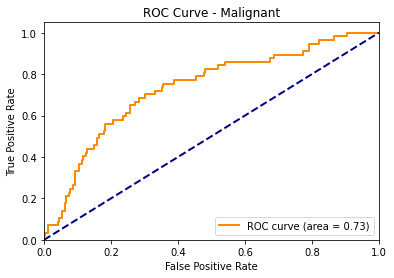

In [54]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Malignant")
plt.legend(loc="lower right")
plt.show()

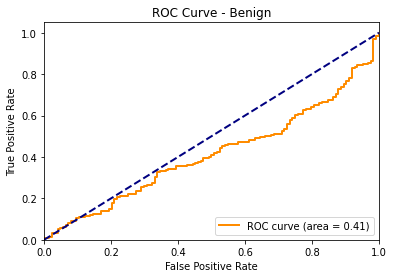

In [56]:
plt.figure()
lw = 2
plt.plot(
    fpr2,
    tpr2,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc2,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Benign")
plt.legend(loc="lower right")
plt.show()

In [57]:
# Averge AUC
(roc_auc2 + roc_auc)/2

0.5736329230333899

Quick accuracy

In [126]:
len(meta_df2[(meta_df2["true_y"] != "none") & (meta_df2["pred_y"] == meta_df2["true_y"])]) / len(meta_df2[meta_df2["true_y"] != "none"])

0.7865497076023392

## Get INbreast image data from DICOM file

In [61]:
import pydicom as dicom

In [65]:
ds = dicom.read_file("../data/INbreast Release 1.0/AllDICOMs/53587744_5fb370d4c1c71974_MG_L_CC_ANON.dcm")
ds2 = dicom.read_file("../data/INbreast Release 1.0/AllDICOMs/22579730_bbd6a3a35438c11b_MG_R_ML_ANON.dcm")

In [67]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.1.136366061213208408441821372183924677041
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.0.100.4.0
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 4.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.1.136366061213208408441821372183924677041
(0008, 0020) Study Date                          DA: ''
(0008, 0023) Content Date                        DA: '20111229'
(0008, 0030) Stud

In [68]:
ds2

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.1.50394126912764181436461208810254667714
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.0.100.4.0
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 4.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.1.50394126912764181436461208810254667714
(0008, 0020) Study Date                          DA: ''
(0008, 0023) Content Date                        DA: '20111229'
(0008, 0030) Study 